In [1]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import time
from scipy.linalg import sqrtm
from scipy.linalg import eigh

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
def make_gaussians(num_gaussians, num_samples, dim=2, mu_range=(-10,10), sigma_range=(1,1)):
    gaussians = []
    mus = []
    sigmas = []
    for _ in range(num_gaussians):
        mu = torch.FloatTensor(dim).uniform_(mu_range[0], mu_range[1])
        mus.append(mu.squeeze())

        A = torch.randn(dim, dim)
        sigma = torch.diag(torch.abs(torch.randn(dim)) + sigma_range[0])

        sigmas.append(sigma.squeeze())

        dist = torch.distributions.MultivariateNormal(mu, sigma)
        samples = dist.sample([num_samples])
        gaussians.append(samples.squeeze())

    return torch.stack(gaussians), torch.stack(mus), torch.stack(sigmas)

def calc_bc_1d(gs):
    '''
    Calculating the barycenter of empirical 1D Gaussians
    
    Parameters:
    gs: Tensor(num_slices, num_gaussians, num_samples) 
    
    Return:
    means, variances of the barycenters, one per slice
    '''
    mus = torch.mean(gs, axis=-1)
    mus = torch.mean(mus,axis=-1)
    vs = torch.var(gs, axis=-1)
    vs = torch.sqrt(vs)
    vs = torch.mean(vs, axis=-1)
    vs = torch.pow(vs, 2)
    return mus, vs

def plot_slices(sample_slices):
    num_slices = sample_slices.shape[0]
    fig, axs = plt.subplots(num_slices, figsize=(10, 3 * num_slices))

    for i in range(num_slices):
        for j in range(sample_slices.shape[1]):
            if j == sample_slices.shape[1] - 1:
                alpha = 1.0 
                linewidth = 4.0  
            else:
                alpha = 0.2
                linewidth = 1.0  
            sns.kdeplot(sample_slices[i, j, :].detach().cpu().numpy(), ax=axs[i], alpha=alpha, linewidth=linewidth)
       

    plt.tight_layout()
    plt.show()
    
def generate_and_plot_slices(gs, bc_mu, bc_sigma, num_samples, num_slices, dim, device, seed=69):
    torch.manual_seed(seed)

    gs = gs.to(device)
    bc_mu = bc_mu.to(device)
    bc_sigma = bc_sigma.to(device)

    dist = torch.distributions.MultivariateNormal(bc_mu, bc_sigma)
    bc_samples = dist.sample([num_samples]).unsqueeze(0).to(torch.double)

    sample_projs = torch.randn(dim, num_slices, dtype=torch.double).to(device)
    sample_slices_gs = torch.matmul(gs.double(), sample_projs)
    sample_slices_gs = sample_slices_gs.permute(2,0,1)

    sample_slices_bc = torch.matmul(bc_samples, sample_projs)
    sample_slices_bc = sample_slices_bc.permute(2,0,1)

    sample_slices = torch.cat([sample_slices_gs, sample_slices_bc], dim=1)

    plot_slices(sample_slices)
    
def calc_bc(gs, num_projs=5000, max_iter=50000, lr=5e-3, err_thresh=5e-3, device=device):
    d = gs.shape[2]
    gs = gs.float().to(device)

    # Initial mean and lower triang matrix for barycenter
    bc_mu = torch.ones(d, device=device, requires_grad=True)
    L = torch.tril(torch.randn((d, d), device=device) * 0.5 + torch.eye(d, device=device) * 1e-3, diagonal=0)
    L.requires_grad = True

    # Cov matrix for barycenter
    bc_sigma = L @ L.T 

    optimizer = torch.optim.Adam([bc_mu, L], lr=lr)
    criterion = torch.nn.MSELoss()

    losses = []
    for i in range(max_iter):
        # Generate random pros
        projs = torch.randn(d, num_projs).to(device)

        # Project Gaussians onto random projs
        slices = torch.matmul(gs, projs)
        slices = slices.permute(2,0,1)
        
        optimizer.zero_grad()

        # Update barycenter cov
        bc_sigma = L @ L.T

        # Project barycenter mean and cov onto random projs
        bc_mu_projected = projs.T @ bc_mu
        bc_sigma_projected = projs.T @ bc_sigma @ projs

        variances = torch.diag(bc_sigma_projected)
   
        # Calculate 1D barycenter for the slices
        mus_1d, vars_1d = calc_bc_1d(slices)   

        loss = criterion(mus_1d, bc_mu_projected) + criterion(vars_1d, variances)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if losses[-1] < err_thresh * losses[0]:
            print(f"Converged in {i} iteration(s)")
            break

    bc_mu = bc_mu.detach().cpu()
    bc_sigma = bc_sigma.detach().cpu()
    return bc_mu, bc_sigma, losses


def calc_bc_lot(gs, max_iter=100, err_thresh=1e-6):
    gs = gs.cpu().numpy()
    d = gs[0].shape[1]
    n_samples = len(gs)
    
    # Initialize reference dist
    mu0 = gs[0].mean(axis=0)
    sigma0 = np.cov(gs[0], rowvar=False)

    for _ in range(max_iter):
        # Initialize list transformed initial barycenters using estimated affines
        muhats = np.empty((n_samples,) + mu0.shape)
        sigmahats = np.empty((n_samples,) + sigma0.shape)
        
        for j, sample in enumerate(gs):
            mu = sample.mean(axis=0)
            sigma = np.cov(sample, rowvar=False)

            sigma0 += np.eye(d) * 1e-6
            sigma += np.eye(d) * 1e-6

            sqrt_sigma0 = sqrtm(sigma0)
            sqrt_sigma = sqrtm(sigma)

            # Calculate affine mapping from reference to current gaussian
            A = sqrt_sigma @ np.linalg.inv(sqrt_sigma0)
            b = mu - A @ mu0

            # Store transformed reference dist
            muhats[j] = A @ mu0.T + b
            sigmahats[j] = A @ sigma0 @ A.T

        mu0_new = muhats.mean(axis=0)
        sigma0_new = sigmahats.mean(axis=0)

        if np.linalg.norm(mu0 - mu0_new) < err_thresh and np.linalg.norm(sigma0 - sigma0_new, 'fro') < err_thresh:
            break

        mu0, sigma0 = mu0_new, sigma0_new

    return torch.tensor(mu0), torch.tensor(sigma0)


In [3]:
num_Gaussians = 3
num_samples = 500
dim = 20
mu_range = (-100,100)
sigma_range = (0.5,40)

gs, mus, sigmas = make_gaussians(num_Gaussians, num_samples, dim=dim, mu_range=mu_range,sigma_range=sigma_range)

In [8]:
tik = time.time()
bc_mu, bc_sigma,losses = calc_bc(gs, num_projs=15000)
tok = time.time()

print("wall clock: ", tok-tik)

Converged in 12250 iteration(s)
wall clock:  74.22587323188782


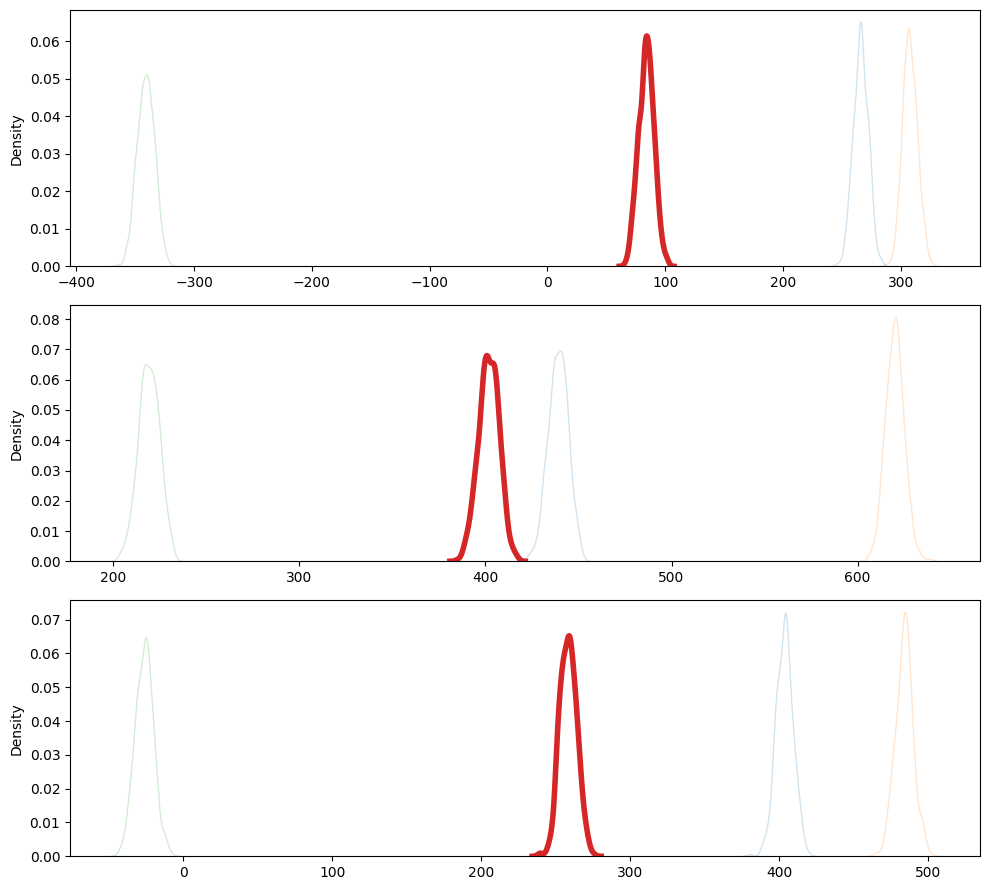

In [9]:
generate_and_plot_slices(gs, bc_mu, bc_sigma, num_samples=num_samples, num_slices=3, dim=dim, device=device, seed=69)

In [6]:
tik = time.time()
bc_mu_lot, bc_sigma_lot = calc_bc_lot(gs)
tok = time.time()

print("wall clock: ", tok-tik)

wall clock:  0.176896333694458


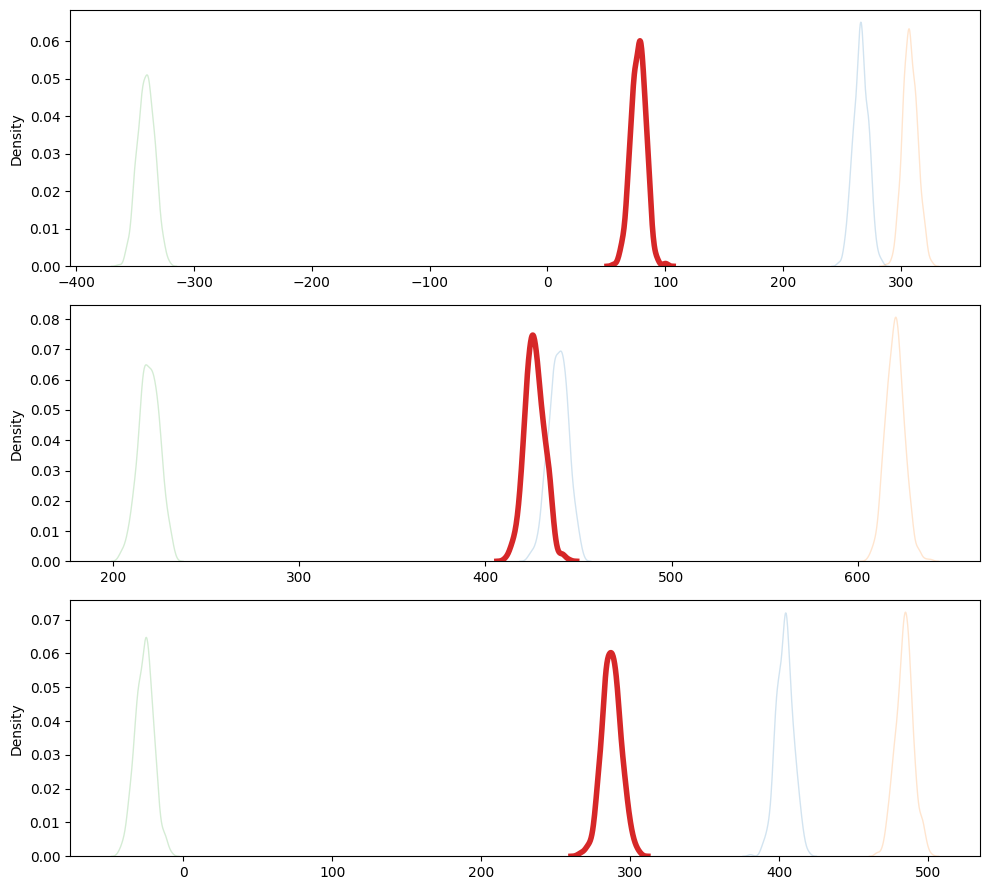

In [7]:
generate_and_plot_slices(gs, bc_mu_lot, bc_sigma_lot, num_samples=num_samples, num_slices=3, dim=dim, device=device)